In [1]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pascal, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pascal *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        fc = k3*np.log(Fc+1.0) # expression of cloud fraction versus convection
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
    fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
    if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
        print('cloud fraction: ',fc_2)
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc_2 * (Flux1 + Flux2) - fc_2*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [2]:
# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

universal_func(So=S, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, T3_init, T4_init, \
               Fa_init, Fc_init))

We have a solution:  (287.9710037145147, 264.84396822121334, 264.84396822121334, 253.73985883356656, 263.7398526263843, 315.5327848242644)


(287.9710037145147,
 264.84396822121334,
 264.84396822121334,
 253.73985883356656,
 263.7398526263843,
 315.5327848242644,
 0.46059414574098545,
 0.009780507716739072,
 0.0028210381501839353,
 0.001059757817088953,
 0.5091406726242967,
 0.9404559051022345,
 0.6534602738321669,
 227.119474751824,
 263.7398526248874,
 23.217571812231245,
 262.35046735858543,
 182.28989504989272,
 96.67104924878336,
 -58.44856441899272,
 {'nfev': 82,
  'fjac': array([[-1.92815418e-03,  1.91056286e-03, -1.64783669e-04,
           1.18891352e-04, -2.60759463e-13,  9.99996295e-01],
         [ 3.69712096e-01,  5.82589031e-01, -4.56910765e-02,
           4.45484819e-01, -5.68646091e-01, -4.60706187e-04],
         [-1.36263906e-01, -2.14725003e-01, -8.18006413e-01,
           4.95131575e-01,  1.45036378e-01, -4.61533346e-05],
         [-5.91215493e-02, -9.31619114e-02,  5.46414190e-01,
           7.30500710e-01,  3.94494285e-01,  6.71863923e-05],
         [ 2.08603750e-01, -7.71907882e-01,  1.40367527e-01,
    

In [3]:
# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

(T1, T2, T3, T4, Fa, Fc,  \
 fc_2, q1, q2, q3, alpha_p, \
 epsilon_2, epsilon_3, OLR_day, OLR_night, \
 Flux1, Flux2, Flux3 ,Flux4, FluxC, \
 info, ier, msg) = universal_func(So=S, assumption='WBG', debug=True, 
                                  p_guess = (T1_init, T2_init, T3_init, T4_init, \
                                             Fa_init, Fc_init))
print("\n")
print("T1 = {} K".format(round(T1,2)))
print("T2 = {} K".format(round(T2,2)))
print("T3 = {} K".format(round(T3,2)))
print("T4 = {} K".format(round(T4,2)))
print("F_a = {} W/m2".format(round(Fa,2)))
print("F_c = {} W/m2".format(round(Fc,2)))
print("dayside cloud fraction = {}".format(round(fc_2,2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1,4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2,4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3,6)))
print("planetary albedo = {}".format(round(alpha_p,3)))
print("dayside emissivity = {}".format(round(epsilon_2,3)))
print("nightside emissivity = {}".format(round(epsilon_3,3)))
print("dayside OLR = {} W/m2".format(round(OLR_day,1)))
print("nightside OLR = {} W/m2".format(round(OLR_night,1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1,1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2,1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC,1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3,1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4,1)))

We have a solution:  (287.40558287056353, 264.6046943446731, 264.85570159924515, 253.77897138977065, 263.8370322726157, 317.18048271984077)


T1 = 287.41 K
T2 = 264.6 K
T3 = 264.86 K
T4 = 253.78 K
F_a = 263.84 W/m2
F_c = 317.18 W/m2
dayside cloud fraction = 0.46
dayside surface specific humidity = 0.0094 kg/kg
dayside atmos specific humidity = 0.0028 kg/kg
nightside atmos specific humidity = 0.001061 kg/kg
planetary albedo = 0.51
dayside emissivity = 0.937
nightside emissivity = 0.654
dayside OLR = 226.6 W/m2
nightside OLR = 263.8 W/m2
dayside surface cooling = 24.3 W/m2
dayside atmospheric cooling = 260.5 W/m2
dayside cloud radiative effect = -58.1 W/m2
nightside surface cooling = 182.4 W/m2
nightside atmospheric cooling = 96.6 W/m2


In [4]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_arr, T2_arr, T3_arr, T4_arr, Fa_arr, Fc_arr, fc_arr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr, q2_arr, q3_arr, alpha_p_arr, epsilon_2_arr, epsilon_3_arr, OLR1_arr, OLR2_arr, Flux1_arr, Flux2_arr, Flux3_arr, Flux4_arr, FluxC_arr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,200,200,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_arr[idx], T2_arr[idx], T3_arr[idx], T4_arr[idx], Fa_arr[idx], Fc_arr[idx], fc_arr[idx], \
        q1_arr[idx],q2_arr[idx],q3_arr[idx],alpha_p_arr[idx],epsilon_2_arr[idx],epsilon_3_arr[idx], \
        OLR1_arr[idx], OLR2_arr[idx], Flux1_arr[idx], Flux2_arr[idx], Flux3_arr[idx], Flux4_arr[idx], FluxC_arr[idx], info,ier,msg = universal_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_arr[idx], T2_arr[idx], T3_arr[idx], T4_arr[idx], Fa_arr[idx], Fc_arr[idx])
    #print('end of loop ',initial_guess)

0 1000.0
We have a solution:  (271.90204533414413, 242.11661227170288, 242.11661227170288, 163.4752750947805, 62.64683393022989, 82.71139136302011)
1 1100.0
We have a solution:  (274.38903147813994, 245.38086672410031, 245.38086672410031, 176.84629492542103, 83.72703916031669, 106.17180501117393)
2 1200.0
We have a solution:  (276.4397756637372, 248.16219243364904, 248.16219243364904, 188.41746541628174, 105.13495214847536, 130.50002158454257)
3 1300.0
We have a solution:  (278.20655168810583, 250.61901113117207, 250.61901113117207, 198.6787061834194, 126.49290922314624, 155.10044907533012)
4 1400.0
We have a solution:  (279.78399323563565, 252.8550749353387, 252.8550749353387, 207.97116162201468, 147.58974140783957, 179.61503794476232)
5 1500.0
We have a solution:  (281.23541781248525, 254.94301817026283, 254.94301817026283, 216.53971240749604, 168.30164750852916, 203.8164450101848)
6 1600.0
We have a solution:  (282.60668584462275, 256.9376477113584, 256.9376477113584, 224.5669429216

### plotting

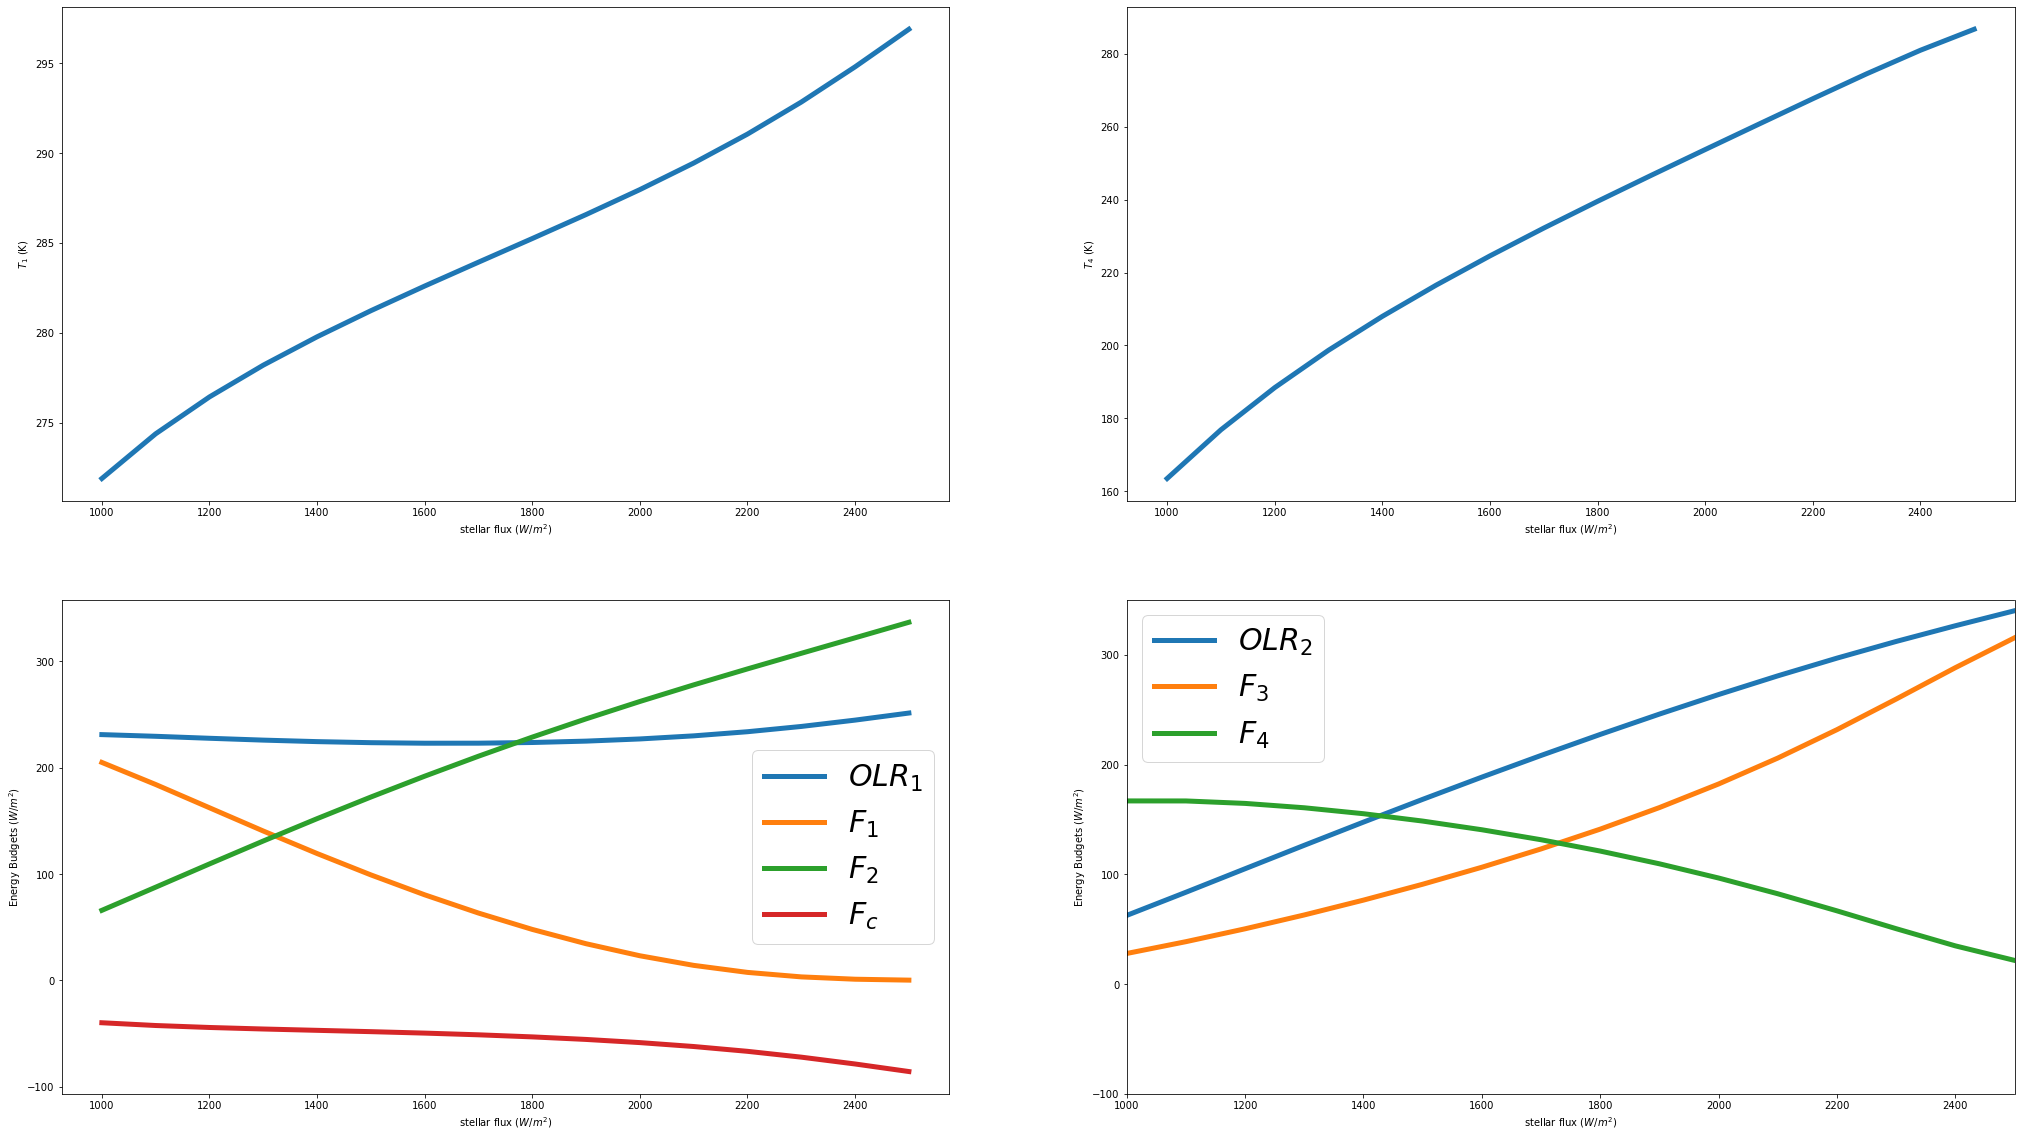

In [5]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Fig 5a, 5b from Yang and Abbot (2014)
    ax[0,0].plot(so, T1_arr, linewidth=5)
    ax[0,0].set_ylabel(r'$T_1$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].plot(so, T4_arr, linewidth=5)
    ax[0,1].set_ylabel(r'$T_4$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Fig 10a from Yang and Abbot (2014)
    ax[1,0].plot(so, OLR1_arr,label = r'$OLR_1$', linewidth=5)
    ax[1,0].plot(so, Flux1_arr, label = r'$F_1$', linewidth=5)
    ax[1,0].plot(so, Flux2_arr, label = r'$F_2$', linewidth=5)
    ax[1,0].plot(so, FluxC_arr, label = r'$F_c$', linewidth=5)
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylim([-100, 350])
    ax[1,0].set_ylabel(r'Energy Budgets ($W/m^2$)')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Fig 10b from Yang and Abbot (2014)
    ax[1,1].plot(so, OLR2_arr, label = r'$OLR_2$', linewidth=5)
    ax[1,1].plot(so, Flux3_arr, label = r'$F_3$', linewidth=5)
    ax[1,1].plot(so, Flux4_arr, label = r'$F_4$', linewidth=5)
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylim([-100, 350])
    ax[1,1].set_ylabel(r'Energy Budgets ($W/m^2$)')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_8panels(so)

Text(0, 0.5, '$\\epsilon \\sigma T^4 (W/m^2)$')

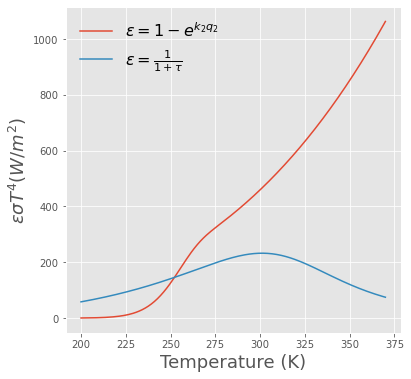

In [15]:
def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau


def epsilon_orig(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
    k2 = 1000
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    #q2_s = ws_2/(1+ws_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2        


T = np.linspace(200,370,200)
epsilon_2_tau = 1/(1+tau(T,273))
epsilon_2 = epsilon_orig(T)

Lr_atm_gh = epsilon_2_tau*sigma*T**4
Lr_atm = epsilon_2*sigma*T**4

plt.rcParams['figure.constrained_layout.use']=False
fig = plt.figure(figsize =(6,6))
plt.style.use('ggplot')
#plt.style.use('default')

plt.plot(T, Lr_atm, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
plt.legend(loc = 'best',fontsize=16, frameon = False)
plt.xlabel('Temperature (K)', fontsize = 18)
plt.ylabel(r'$\epsilon \sigma T^4 (W/m^2)$', fontsize = 18)


In [16]:
def a(T):         # temperature varying absorption
    Tref0 = 280   # Temperature of full absorption limit 
    a0 = 0.9      # Max water vapor absorption to sunlight
    ka = 1e4      # exponetional factor (like CC relation)
    if T <= Tref0:
        a = a0*np.exp(-ka*(1/T - 1/Tref0))
    else:
        a = a0
    return a

# def cld_frc(Fc):
#     # double check for cloud fraction, smaller than 0?
#     k3 = 0.08
        
#     nele = len(Fc)
#     fc = np.zeros(nele)  
#     for idx, F in enumerate(Fc):
#         if F + 1.0 <= 0:
#             fc[idx] = 0
#         else:
#             fc[idx] = k3*np.log(F + 1.0)
#             if fc[idx] >= 1:
#                 fc[idx] = 1
#     return fc

def cld_frc(Fc):
    k3 = 0.08
    if Fc + 1.0 <= 0:
#     print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
        fc = 0
    else:
        fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
        if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
            print("Cloud fraction too high, corrected as 1")
            fc = 1
    return fc

Fc = np.linspace(-200,370,200)
fc = a(Fc)

fig = plt.figure(figsize =(6,6))
plt.style.use('ggplot')

plt.plot(Fc, fc, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
# plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
plt.legend(loc = 'best',fontsize=16, frameon = False)
plt.xlabel('convective flux', fontsize = 18)
plt.ylabel(r'cloud fraction', fontsize = 18)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def solar_abs_func(So=1360, Fo = 0, epsilon0 = 0.5, a0 = 0, mm_dry = 0.028, LW = 'feedback', SW = 'feedback', assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)

    def alpha(fc):
        alpha_p = 0.09 + fc - 0.09*fc
        return alpha_p
    
    def cld_frc(Fc):
        if Fc + 1.0 <= 0:
#         print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        return fc

    def Tv(T, mass_ratio, w):               # virtual temperature
        Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
        return Tv

    def a(T):
        if SW == 'feedback': # temperature varying absorption
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e4      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
        elif SW == 'constant':
            a = a0
        return a
        
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 
        
        if LW == 'feedback':
            ### Constants
            #print('solving or calculating ...')
            es0 = 611.2         # reference pressure for CC relation
            M = 0.018           # molar mass of water vapor
            To = 273.15         # reference temperature for CC relation
            mass_ratio = M/mm_dry    # mass ratio between vapor and dry air

            H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere       

            Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
            Cpd = 1005.7                # heat capacity of dry air in J/kg/K
            Cpv = 1996                  # heat capacity of vapor in J/kg/K 
            L = 2.501e6                 # latent heat of vaporization in J/kg

            RH1 = 0.9 # Dayside surface relative humidity
            RH2 = 0.8 # Dayside atmosphere relative humidity
            RH3 = 0.3 # Nightside atmosphere relative humidity

            # water vapor calculations for dayside surface
            es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
            # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
            ws_1 = mass_ratio*es_1/(Po - es_1)               
            w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
            q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
            q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

            # water vapor calcaulations for dayside atmosphere
            es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
            ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
            w_2 = RH2 * ws_2
            q2 = w_2/(1+w_2)
            q2_s = ws_2/(1+ws_2)

            # water vapor calculations for nightside atmosphere
            es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
            ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
            w_3 = RH3 * ws_3
            q3 = w_3/(1+w_3)

            Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
            Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos

            k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
            k2 = 5000 # Relates water vapor to the infrared opacity (need to be checked)

            epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
            epsilon_3 = 1 - np.exp(-k2*q3)
        elif LW == 'constant':
            epslilon_2 = epsilon0
            epsillon_3 = epsilon0
            
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer

#         fc = cld_frc(Fc)        
#         alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
#         # Corrected dayside surface energy equation
#         Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

#         # Corrected dayside atmos energy equation
#         Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha(cld_frc(Fc)))*(1-a(T2)) - Fc - Fo + (1-cld_frc(Fc))*epsilon_2*sigma*T2**4 + cld_frc(Fc)*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2) + Fc - Fa + (1-cld_frc(Fc))*epsilon_2*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - 2*(1-cld_frc(Fc))*epsilon_2*sigma*T2**4 - 2*cld_frc(Fc)*sigma*Tc**4
        
        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
#         # dayside outgoing longwave radiation
#         OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
                
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1, q2, q3, epsilon_2, epsilon_3, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    q1,q2,q3,epsilon_2,epsilon_3, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    
    fc = cld_frc(Fc)
#     FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    # Ourput everything
    
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,epsilon_2,epsilon_3,Flux1,Flux2,Flux3,Flux4)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,epsilon_2,epsilon_3,Flux1,Flux2,Flux3,Flux4,info,ier,msg)
    
#     # Ourput everything
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [18]:
# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

solar_abs_func(So=S, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, T3_init, T4_init, \
               Fa_init, Fc_init))

We have a solution:  (314.08567479614555, 299.3002533372828, 299.3002533372828, 313.25816237981144, 455.0, -5.792222680646244)


(314.08567479614555,
 299.3002533372828,
 299.3002533372828,
 313.25816237981144,
 455.0,
 -5.792222680646244,
 0,
 0.047987118245943226,
 0.030457815126245933,
 0.011643324564237487,
 1.0,
 1.0,
 0.0,
 455.00000000000006,
 455.00000000000006,
 0.0,
 {'nfev': 44,
  'fjac': array([[-8.06905684e-04,  8.06776286e-04, -1.02984764e-05,
           1.01965670e-05, -1.48293103e-13,  9.99999349e-01],
         [-1.51009166e-02, -9.42862368e-01, -2.26357476e-01,
           1.86557232e-01,  1.57291625e-01,  7.44261088e-04],
         [ 4.28588131e-03,  2.67603105e-01, -8.62790977e-01,
           4.10569256e-01, -1.24075684e-01, -2.25509513e-04],
         [-1.70513955e-03, -1.06475150e-01, -4.21173295e-01,
          -8.77303936e-01, -2.03987710e-01,  8.91338427e-05],
         [ 4.56535079e-02, -1.67327652e-01,  1.64024684e-01,
           1.64024722e-01, -9.57135820e-01,  1.71850884e-04],
         [-9.98832214e-01,  7.93607852e-03,  7.93612309e-03,
           7.93595475e-03, -4.63098816e-02, -8.12365

In [19]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr, T2_brr, T3_brr, T4_brr, Fa_brr, Fc_brr, fc_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr, q2_brr, q3_brr, epsilon_2_brr, epsilon_3_brr, Flux1_brr, Flux2_brr, Flux3_brr, Flux4_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx],\
        q1_brr[idx],q2_brr[idx],q3_brr[idx],epsilon_2_brr[idx],epsilon_3_brr[idx], \
        Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr[idx], q2_brr[idx], q3_brr[idx], epsilon_2_brr[idx], epsilon_3_brr[idx], Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx]= math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (256.82628944173683, 224.7468927852311, 224.7468927852311, 147.7320940044827, 42.12120614074067, 75.12910940679625)
1 850.0
We have a solution:  (258.89780022291984, 226.92328572283893, 226.92328572283893, 157.05723130849762, 52.926520126554195, 86.17357621444243)
2 900.0
We have a solution:  (260.693371423206, 228.8555930709278, 228.8555930709278, 165.4838076587334, 64.10213207227747, 97.83312819623728)
3 950.0
We have a solution:  (262.28102223301545, 230.60291243544222, 230.60291243544222, 173.18230542455356, 75.48747196867585, 109.8738942070498)
4 1000.0
We have a solution:  (263.7094499241521, 232.20843467983914, 232.20843467983914, 180.28643761059044, 86.96363094325719, 122.12591966129861)
5 1050.0
We have a solution:  (265.0146556811883, 233.70485191854274, 233.70485191854274, 186.90265802699707, 98.44263071462898, 134.4631391743137)
6 1100.0
We have a solution:  (266.2240775391686, 235.11776482398142, 235.11776482398142, 193.11699653934159, 109.8587

In [20]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, T3_crr, T4_crr, Fa_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, q3_crr, epsilon_2_crr, epsilon_3_crr, Flux1_crr, Flux2_crr, Flux3_crr, Flux4_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx], fc_crr[idx],\
        q1_crr[idx],q2_crr[idx],q3_crr[idx],epsilon_2_crr[idx],epsilon_3_crr[idx], \
        Flux1_crr[idx], Flux2_crr[idx], Flux3_crr[idx], Flux4_crr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_crr[idx-1], T2_crr[idx-1], T3_crr[idx-1], T4_crr[idx-1], Fa_crr[idx-1], Fc_crr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx], fc_crr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_crr[idx], q2_crr[idx], q3_crr[idx], epsilon_2_crr[idx], epsilon_3_crr[idx], Flux1_crr[idx], Flux2_crr[idx], Flux3_crr[idx], Flux4_crr[idx]= math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)
1 2450.0
We have a solution:  (327.3224974253483, 313.82589496607216, 313.82589496607216, 328.4612093228802, 549.9689399242601, 0.29166000401157666)
2 2400.0
We have a solution:  (325.91944216188324, 312.338884287668, 312.338884287668, 326.904851694303, 539.6190553483178, 0.25150786050937163)
3 2350.0
We have a solution:  (324.513942078017, 310.8392042032729, 310.8392042032729, 325.3352338202154, 529.3296393327346, 0.20864714800962558)
4 2300.0
We have a solution:  (323.1072151034426, 309.32721871176693, 309.32721871176693, 323.7527366746098, 519.1054704296015, 0.1630263497224169)
5 2250.0
We have a solution:  (321.7005333206329, 307.8033286084488, 307.8033286084488, 322.1577797439686, 508.95139249822165, 0.11463611616437595)
6 2200.0
We have a solution:  (320.2952125527355, 306.26796808102176, 306.26796808102176, 320.55081746440004, 498.8

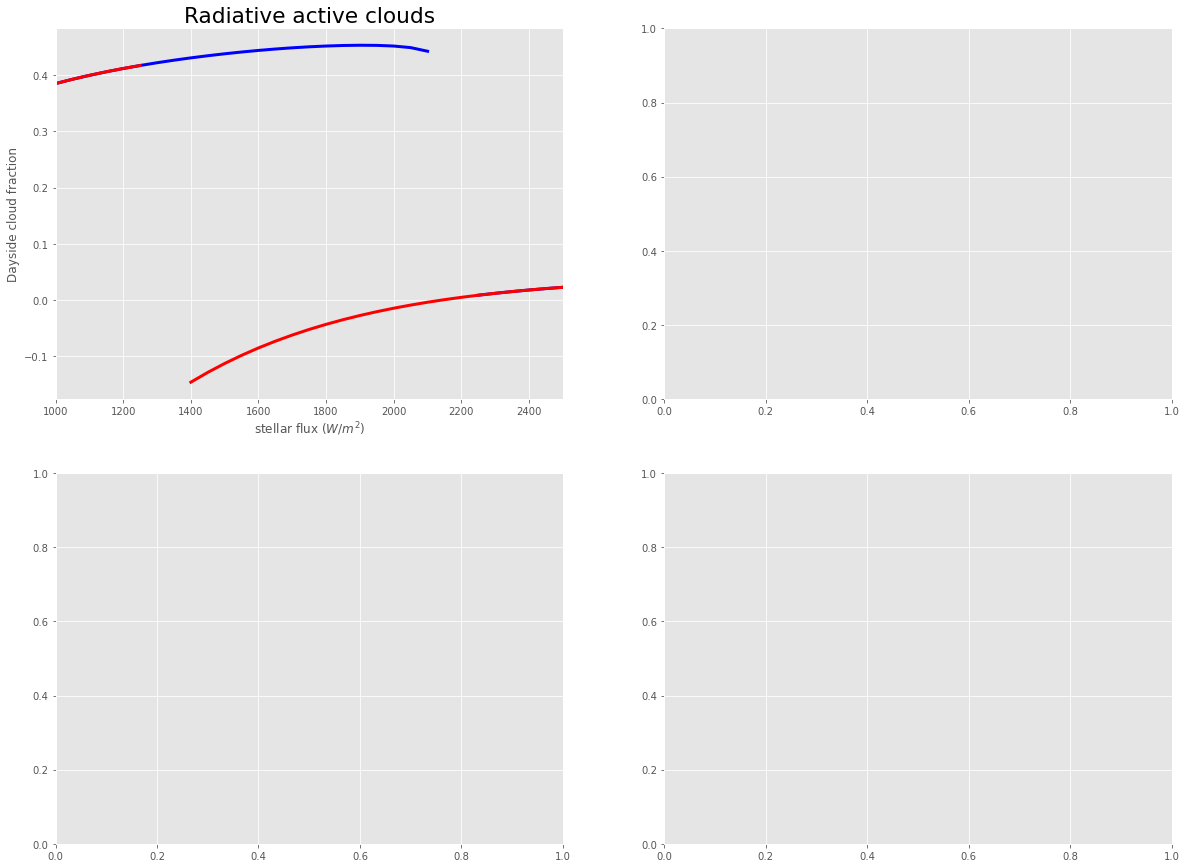

In [21]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.5
    
    fig, ax = plt.subplots(2, 2, figsize=(20,15)) 
    plt.rc('font', size = 15) 

    # Cloud fraction
    ax[0,0].plot(np.flip(so), fc_brr,'-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0,0].plot(so, fc_crr,'-', color = 'red',linewidth=3, label = r'warm start')
    ax[0,0].set_xlim([1000, 2500])
    ax[0,0].set_ylabel("Dayside cloud fraction")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'Radiative active clouds')
    
#     # Albedo
#     ax[0,1].plot(np.flip(so), alpha_p_brr, '-', color = 'blue',linewidth=3, label = "cold start")
#     ax[0,1].plot(so, alpha_p_crr, '-', color = 'red', linewidth=3, label = "warm start")
#     ax[0,1].set_ylabel("Albedo")
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,1].set_title(r'Radiative active clouds')
#     ax[0,1].legend()
        
#     # Cloud fraction
#     ax[1,0].plot(np.flip(so), fc_brr1,'-', color = 'blue',linewidth=3, label = r'cold start')
#     ax[1,0].plot(so, fc_crr1,'-', color = 'red',linewidth=3, label = r'warm start')
#     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_ylabel("Dayside cloud fraction")
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].set_title(r'Radiative inactive clouds')
    
#     # Albedo
#     ax[1,1].plot(np.flip(so), alpha_p_brr1, '-', color = 'blue',linewidth=3, label = "cold start")
#     ax[1,1].plot(so, alpha_p_crr1, '-', color = 'red', linewidth=3, label = "warm start")
#     ax[1,1].set_ylabel("Albedo")
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].set_title(r'Radiative inactive clouds')
#     ax[1,1].legend()

#     # Cloud fraction
#     ax[2,0].plot(np.flip(so), fc_brr2,'-', color = 'blue',linewidth=3, label = r'cold start')
#     ax[2,0].plot(so, fc_crr2,'-', color = 'red',linewidth=3, label = r'warm start')
#     ax[2,0].set_xlim([1000, 2500])
#     ax[2,0].set_ylabel("Dayside cloud fraction")
#     ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[2,0].set_title(r'SW inactive clouds')
    
#     # Albedo
#     ax[2,1].plot(np.flip(so), alpha_p_brr2, '-', color = 'blue',linewidth=3, label = "cold start")
#     ax[2,1].plot(so, alpha_p_crr2, '-', color = 'red', linewidth=3, label = "warm start")
#     ax[2,1].set_ylabel("Albedo")
#     ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[2,1].set_title(r'SW inactive clouds')
#     ax[2,1].legend()
    
#     # Cloud fraction
#     ax[3,0].plot(np.flip(so), fc_brr3,'-', color = 'blue',linewidth=3, label = r'cold start')
#     ax[3,0].plot(so, fc_crr3,'-', color = 'red',linewidth=3, label = r'warm start')
#     ax[3,0].set_xlim([1000, 2500])
#     ax[3,0].set_ylabel("Dayside cloud fraction")
#     ax[3,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[3,0].set_title(r'LW inactive clouds')
    
#     # Albedo
#     ax[3,1].plot(np.flip(so), alpha_p_brr3, '-', color = 'blue',linewidth=3, label = "cold start")
#     ax[3,1].plot(so, alpha_p_crr3, '-', color = 'red', linewidth=3, label = "warm start")
#     ax[3,1].set_ylabel("Albedo")
#     ax[3,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[3,1].set_title(r'LW inactive clouds')
#     ax[3,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

In [22]:
print(fc_brr)

[0.34659446 0.3574321  0.36747463 0.37667148 0.38505661 0.39269597
 0.39966321 0.40602902 0.41185685 0.41720162 0.42210975 0.4266195
 0.43076153 0.43455916 0.4380284  0.44117767 0.44400715 0.44650813
 0.44866313 0.45044781 0.45183306 0.45277959 0.45321489 0.45299097
 0.4518075  0.44899975 0.44255004        nan        nan 0.00868225
 0.01208204 0.01516013 0.01794793 0.02047426 0.02276553]


In [23]:
print(fc_crr)

[ 0.02276551  0.02047426  0.01794793  0.01516013  0.01208204  0.00868224
  0.00492655  0.00077784 -0.00380416 -0.00886309 -0.01444617 -0.02060445
 -0.02739314 -0.03487189 -0.04310524 -0.05216308 -0.06212128 -0.07306239
 -0.08507659 -0.09826283 -0.11273029 -0.12860013 -0.1460078          nan
         nan  0.41720162  0.41185685  0.40602902  0.39966321  0.39269597
  0.38505661  0.37667148  0.36747463  0.3574321   0.34659446]


In [24]:
print(Fc_crr)

[ 3.29188928e-01  2.91660004e-01  2.51507861e-01  2.08647148e-01
  1.63026350e-01  1.14636116e-01  6.35175462e-02  9.77041196e-03
 -4.64391534e-02 -1.04872096e-01 -1.65211701e-01 -2.27061417e-01
 -2.89946009e-01 -3.53316736e-01 -4.16561066e-01 -4.79017355e-01
 -5.39994122e-01 -5.98793832e-01 -6.54739931e-01 -7.07205822e-01
 -7.55643875e-01 -7.99612373e-01 -8.38798074e-01             nan
             nan  1.83015556e+02  1.71123217e+02  1.59030238e+02
  1.46789676e+02  1.34463139e+02  1.22125920e+02  1.09873894e+02
  9.78331282e+01  8.61735763e+01  7.51291092e+01]


In [25]:
def cld_frc(Fc):
    # double check for cloud fraction, smaller than 0?
    k3 = 0.08
        
    nele = len(Fc)
    fc = np.zeros(nele)  
    for idx, F in enumerate(Fc):
        print('Fc is')
        print(F)
        print('Fc + 1 is')
        print(F+1.0)
        if F + 1.0 <= 0:
            fc[idx] = 0
        else:
            fc[idx] = k3*np.log(F + 1.0)
            if fc[idx] >= 1:
                fc[idx] = 1
        print('cloud fraction is')
        print(fc[idx])
        print('\n')
    return fc

In [26]:
fc_crrr = cld_frc(Fc_crr)
print(fc_crrr)

Fc is
0.3291889283610317
Fc + 1 is
1.3291889283610316
cloud fraction is
0.022765514233022192


Fc is
0.29166000401157666
Fc + 1 is
1.2916600040115767
cloud fraction is
0.020474257275144906


Fc is
0.25150786050937163
Fc + 1 is
1.2515078605093717
cloud fraction is
0.017947929019233606


Fc is
0.20864714800962558
Fc + 1 is
1.2086471480096255
cloud fraction is
0.015160133969414681


Fc is
0.1630263497224169
Fc + 1 is
1.163026349722417
cloud fraction is
0.012082042397035536


Fc is
0.11463611616437595
Fc + 1 is
1.1146361161643759
cloud fraction is
0.00868223987451807


Fc is
0.06351754624625823
Fc + 1 is
1.0635175462462583
cloud fraction is
0.0049265483286479285


Fc is
0.009770411960190595
Fc + 1 is
1.0097704119601907
cloud fraction is
0.000777839209785761


Fc is
-0.046439153434277694
Fc + 1 is
0.9535608465657223
cloud fraction is
-0.003804163365201872


Fc is
-0.10487209638131488
Fc + 1 is
0.8951279036186851
cloud fraction is
-0.008863092947732295


Fc is
-0.16521170131297758
Fc + 1 is


In [27]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr, T2_brr, T3_brr, T4_brr, Fa_brr, Fc_brr, fc_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr, q2_brr, q3_brr, alpha_p_brr, epsilon_2_brr, epsilon_3_brr, OLR1_brr, OLR2_brr, Flux1_brr, Flux2_brr, Flux3_brr, Flux4_brr, FluxC_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx], \
        q1_brr[idx],q2_brr[idx],q3_brr[idx],alpha_p_brr[idx],epsilon_2_brr[idx],epsilon_3_brr[idx], \
        OLR1_brr[idx], OLR2_brr[idx], Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx], FluxC_brr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr[idx], q2_brr[idx], q3_brr[idx], alpha_p_brr[idx], epsilon_2_brr[idx], epsilon_3_brr[idx], OLR1_brr[idx], OLR2_brr[idx], Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx], FluxC_brr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (256.82628944173683, 224.7468927852311, 224.7468927852311, 147.7320940044827, 42.12120614074067, 75.12910940679625)


ValueError: not enough values to unpack (expected 23, got 19)

In [28]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, T3_crr, T4_crr, Fa_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, q3_crr, alpha_p_crr, epsilon_2_crr, epsilon_3_crr, OLR1_crr, OLR2_crr, Flux1_crr, Flux2_crr, Flux3_crr, Flux4_crr, FluxC_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx], fc_crr[idx], \
        q1_crr[idx],q2_crr[idx],q3_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx],epsilon_3_crr[idx], \
        OLR1_crr[idx], OLR2_crr[idx], Flux1_crr[idx], Flux2_crr[idx], Flux3_crr[idx], Flux4_crr[idx], FluxC_crr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr[idx]= math.nan
        T2_crr[idx]= math.nan
        T3_crr[idx]= math.nan
        T4_crr[idx]= math.nan
    else:
        initial_guess = (T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)


ValueError: not enough values to unpack (expected 23, got 19)

NameError: name 'T1_brr1' is not defined

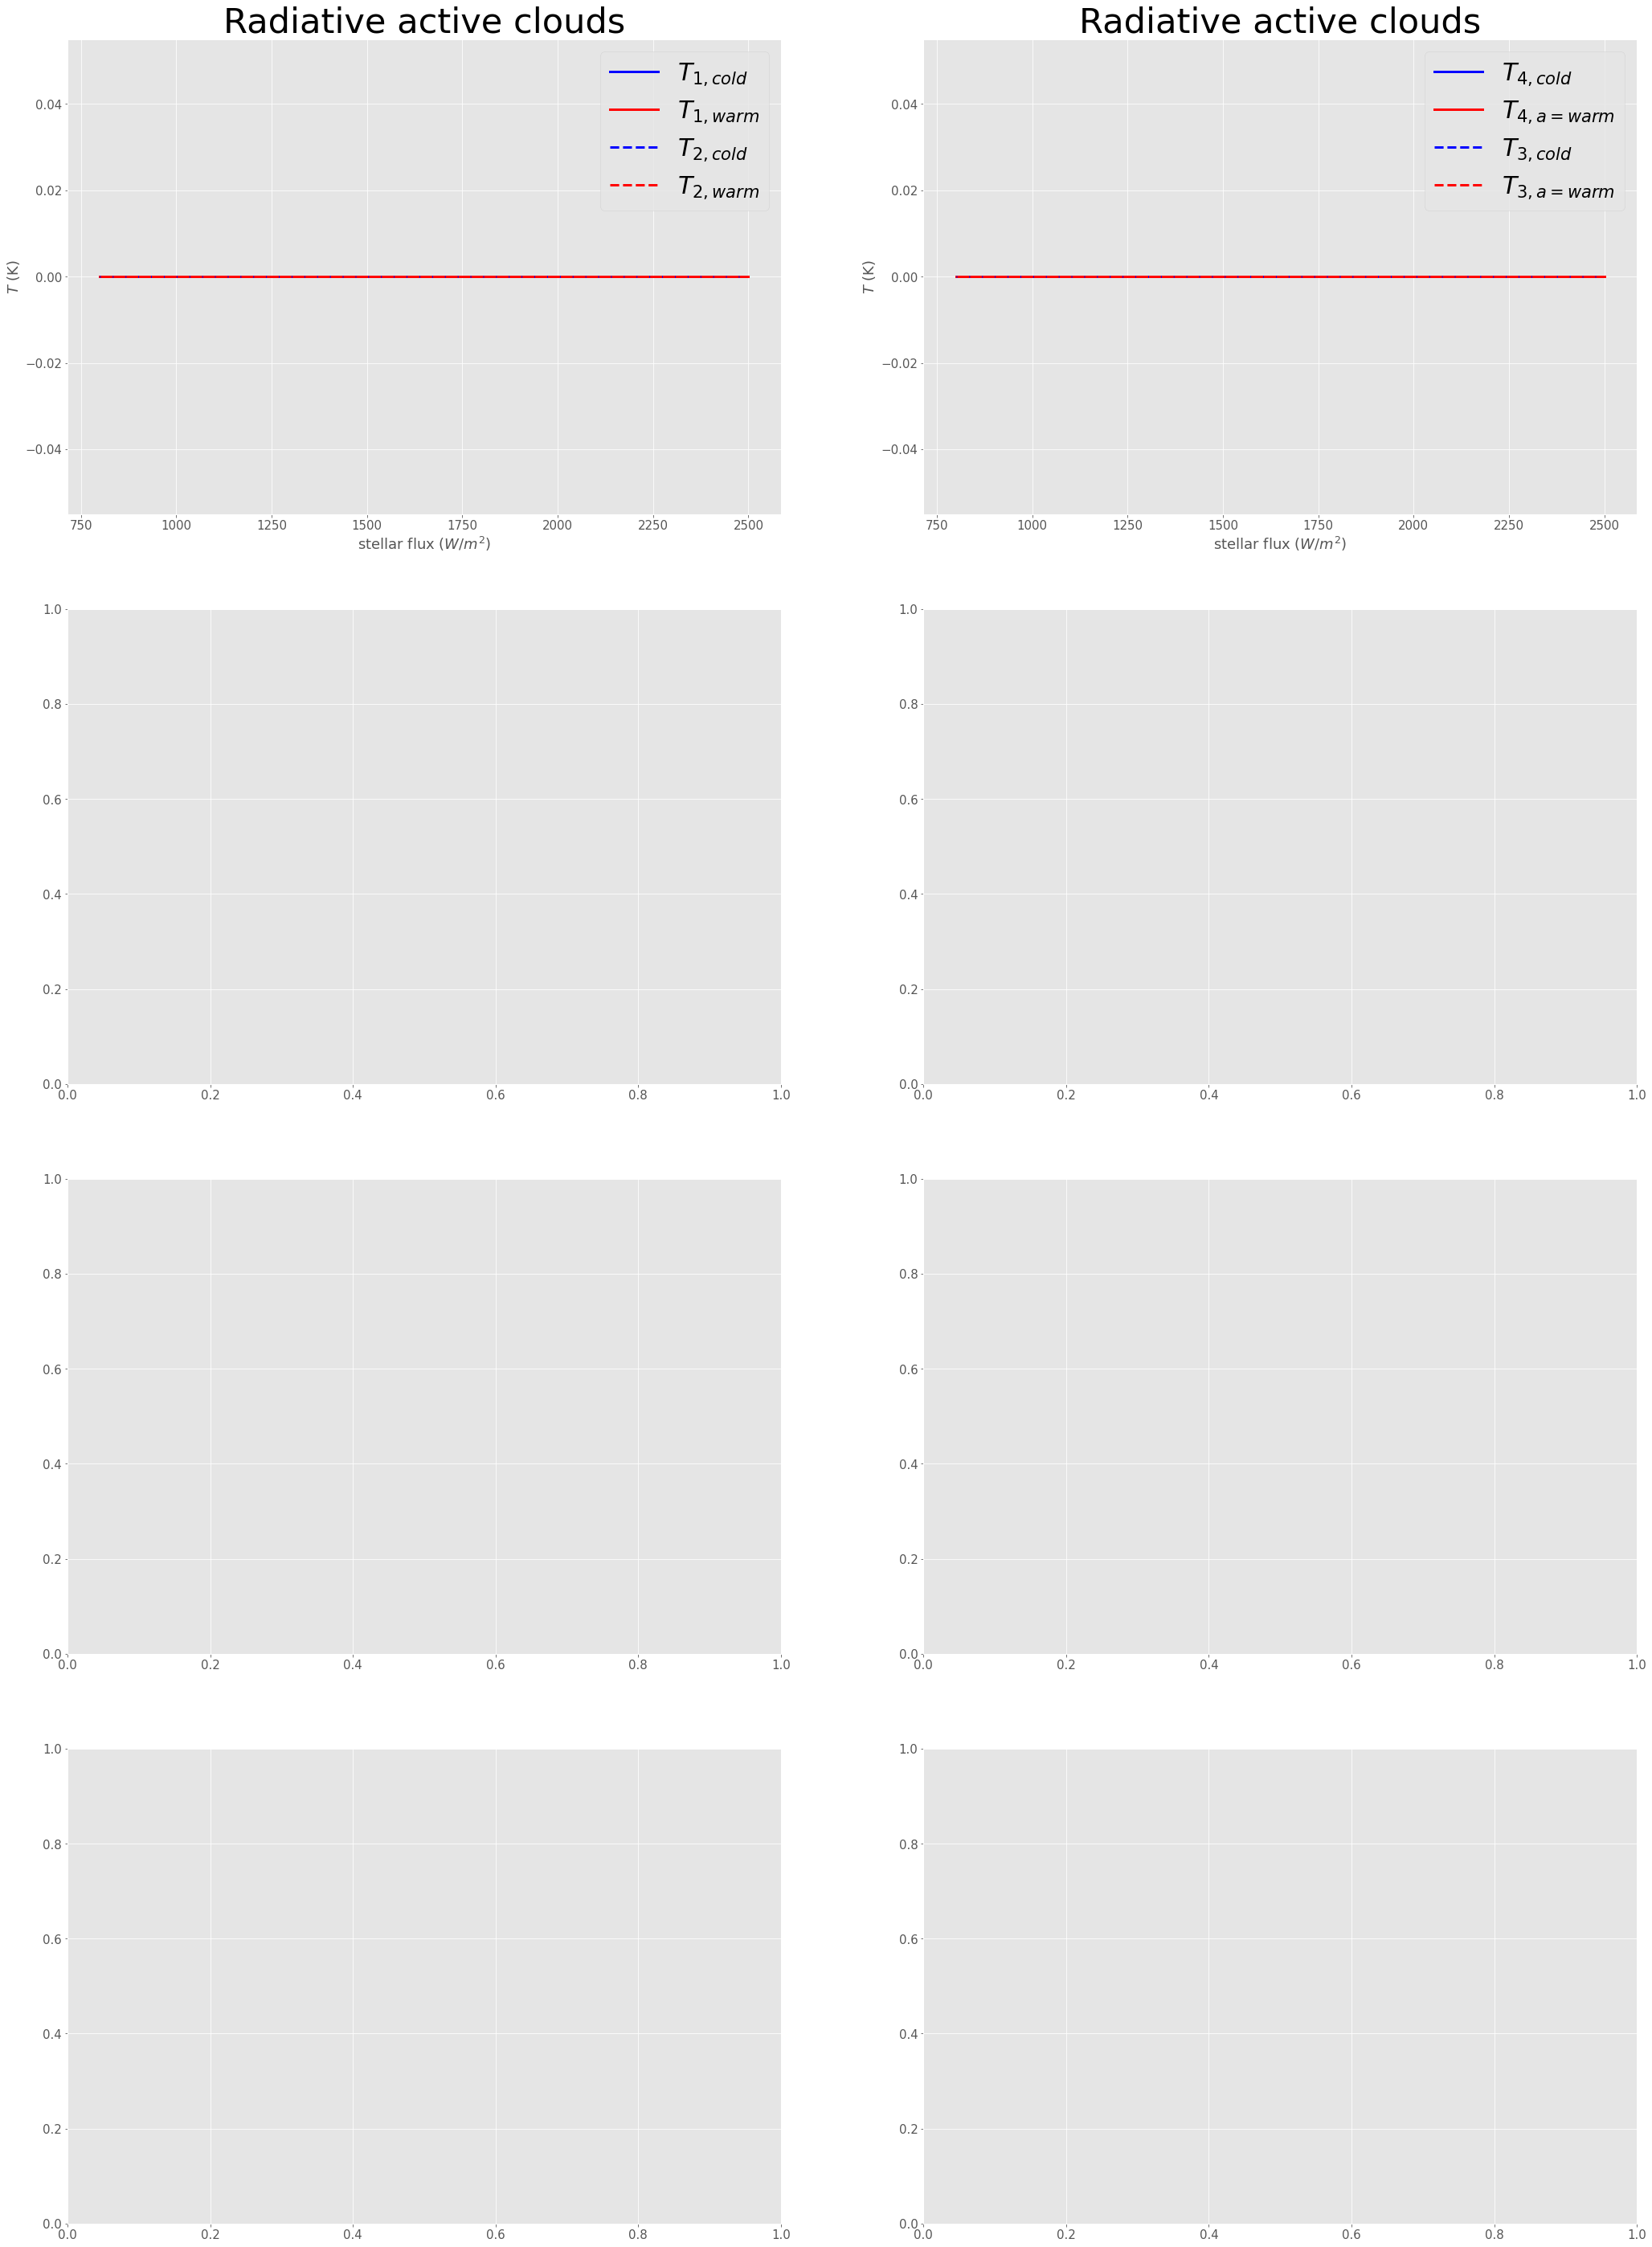

In [29]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(4, 2, figsize=(35,50)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_brr, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[0,0].plot(so, T1_crr, '-', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[0,0].plot(np.flip(so), T2_brr, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[0,0].plot(so, T2_crr, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'Radiative active clouds')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T4_brr, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold}$')
    ax[0,1].plot(so, T4_crr, '-', color = 'red', linewidth=3, label = r'$T_{4, a=warm}$')
    ax[0,1].plot(np.flip(so), T3_brr, '--', color = 'blue', linewidth=3, label = r'$T_{3, cold}$')
    ax[0,1].plot(so, T3_crr, '--', color = 'red',linewidth=3, label = r'$T_{3, a=warm}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'Radiative active clouds')
    ax[0,1].legend()
    
    # Dayside temperature structure
    ax[1,0].plot(np.flip(so), T1_brr1, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[1,0].plot(so, T1_crr1, '-', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[1,0].plot(np.flip(so), T2_brr1, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[1,0].plot(so, T2_crr1, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[1,0].set_ylabel(r'$T$ (K)')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].set_title(r'Radiative inactive clouds')
    ax[1,0].legend()
    
    # Nightside temperature structure
    ax[1,1].plot(np.flip(so), T4_brr1, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold}$')
    ax[1,1].plot(so, T4_crr1, '-', color = 'red', linewidth=3, label = r'$T_{4, warm}$')
    ax[1,1].plot(np.flip(so), T3_brr1, '--', color = 'blue', linewidth=3, label = r'$T_{3, cold}$')
    ax[1,1].plot(so, T3_crr1, '--', color = 'red',linewidth=3, label = r'$T_{3, warm}$')
    ax[1,1].set_ylabel(r'$T$ (K)')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].set_title(r'Radiative inactive clouds')
    ax[1,1].legend()
    
    # Dayside temperature structure
    ax[2,0].plot(np.flip(so), T1_brr2, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[2,0].plot(so, T1_crr2, '-', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[2,0].plot(np.flip(so), T2_brr2, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[2,0].plot(so, T2_crr2, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[2,0].set_ylabel(r'$T$ (K)')
    ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,0].set_title(r'Shortwave inactive clouds')
    ax[2,0].legend()
    
    # Nightside temperature structure
    ax[2,1].plot(np.flip(so), T4_brr2, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold}$')
    ax[2,1].plot(so, T4_crr2, '-', color = 'red', linewidth=3, label = r'$T_{4, warm}$')
    ax[2,1].plot(np.flip(so), T3_brr2, '--', color = 'blue', linewidth=3, label = r'$T_{3, cold}$')
    ax[2,1].plot(so, T3_crr2, '--', color = 'red',linewidth=3, label = r'$T_{3, warm}$')
    ax[2,1].set_ylabel(r'$T$ (K)')
    ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,1].set_title(r'Shortwave inactive clouds')
    ax[2,1].legend()
    
    # Dayside temperature structure
    ax[3,0].plot(np.flip(so), T1_brr3, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold}$')
    ax[3,0].plot(so, T1_crr3, '-', color = 'red', linewidth=3, label = r'$T_{1, warm}$')
    ax[3,0].plot(np.flip(so), T2_brr3, '--', color = 'blue', linewidth=3, label = r'$T_{2, cold}$')
    ax[3,0].plot(so, T2_crr3, '--', color = 'red',linewidth=3, label = r'$T_{2, warm}$')
    ax[3,0].set_ylabel(r'$T$ (K)')
    ax[3,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,0].set_title(r'Longwave inactive clouds')
    ax[3,0].legend()
    
    # Nightside temperature structure
    ax[3,1].plot(np.flip(so), T4_brr3, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold}$')
    ax[3,1].plot(so, T4_crr3, '-', color = 'red', linewidth=3, label = r'$T_{4, warm}$')
    ax[3,1].plot(np.flip(so), T3_brr3, '--', color = 'blue', linewidth=3, label = r'$T_{3, cold}$')
    ax[3,1].plot(so, T3_crr3, '--', color = 'red',linewidth=3, label = r'$T_{3, warm}$')
    ax[3,1].set_ylabel(r'$T$ (K)')
    ax[3,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,1].set_title(r'Longwave inactive clouds')
    ax[3,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [ ]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_cloud_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 5000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
#         alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        alpha_p = 0.09  # planetary albedo decorrelats with dayside cloud fraction
    
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e4      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + 1*epsilon_2*sigma*T2**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + 1*epsilon_2*sigma*T1**4 - 2*1*epsilon_2*sigma*T2**4
        
#         # Corrected dayside surface energy equation
#         Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

#         # Corrected dayside atmos energy equation
#         Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
#     FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    FluxC = 0
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [30]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr1, T2_brr1, T3_brr1, T4_brr1, Fa_brr1, Fc_brr1, fc_brr1 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr1, q2_brr1, q3_brr1, alpha_p_brr1, epsilon_2_brr1, epsilon_3_brr1, OLR1_brr1, OLR2_brr1, Flux1_brr1, Flux2_brr1, Flux3_brr1, Flux4_brr1, FluxC_brr1 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr1[idx], T2_brr1[idx], T3_brr1[idx], T4_brr1[idx], Fa_brr1[idx], Fc_brr1[idx], fc_brr1[idx], \
        q1_brr1[idx],q2_brr1[idx],q3_brr1[idx],alpha_p_brr1[idx],epsilon_2_brr1[idx],epsilon_3_brr1[idx], \
        OLR1_brr1[idx], OLR2_brr1[idx], Flux1_brr1[idx], Flux2_brr1[idx], Flux3_brr1[idx], Flux4_brr1[idx], FluxC_brr1[idx], info,ier,msg = no_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr1[idx], T2_brr1[idx], T3_brr1[idx], T4_brr1[idx], Fa_brr1[idx], Fc_brr1[idx], fc_brr1[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr1[idx], q2_brr1[idx], q3_brr1[idx], alpha_p_brr1[idx], epsilon_2_brr1[idx], epsilon_3_brr1[idx], OLR1_brr1[idx], OLR2_brr1[idx], Flux1_brr1[idx], Flux2_brr1[idx], Flux3_brr1[idx], Flux4_brr1[idx], FluxC_brr1[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_brr1[idx], T2_brr1[idx], T3_brr1[idx], T4_brr1[idx], Fa_brr1[idx], Fc_brr1[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0


NameError: name 'no_cloud_func' is not defined

In [31]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr1, T2_crr1, T3_crr1, T4_crr1, Fa_crr1, Fc_crr1, fc_crr1 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr1, q2_crr1, q3_crr1, alpha_p_crr1, epsilon_2_crr1, epsilon_3_crr1, OLR1_crr1, OLR2_crr1, Flux1_crr1, Flux2_crr1, Flux3_crr1, Flux4_crr1, FluxC_crr1 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr1[idx], T2_crr1[idx], T3_crr1[idx], T4_crr1[idx], Fa_crr1[idx], Fc_crr1[idx], fc_crr1[idx], \
        q1_crr1[idx],q2_crr1[idx],q3_crr1[idx],alpha_p_crr1[idx],epsilon_2_crr1[idx],epsilon_3_crr1[idx], \
        OLR1_crr1[idx], OLR2_crr1[idx], Flux1_crr1[idx], Flux2_crr1[idx], Flux3_crr1[idx], Flux4_crr1[idx], FluxC_crr1[idx], info,ier,msg = no_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr1[idx], T2_crr1[idx], T3_crr1[idx], T4_crr1[idx], Fa_crr1[idx], Fc_crr1[idx], fc_crr1[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_crr1[idx], q2_crr1[idx], q3_crr1[idx], alpha_p_crr1[idx], epsilon_2_crr1[idx], epsilon_3_crr1[idx], OLR1_crr1[idx], OLR2_crr1[idx], Flux1_crr1[idx], Flux2_crr1[idx], Flux3_crr1[idx], Flux4_crr1[idx], FluxC_crr1[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_crr1[idx], T2_crr1[idx], T3_crr1[idx], T4_crr1[idx], Fa_crr1[idx], Fc_crr1[idx])
    #print('end of loop ',initial_guess)

0 2500.0


NameError: name 'no_cloud_func' is not defined

In [32]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_SW_cloud_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 5000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
#         alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        alpha_p = 0.09  # planetary albedo decorrelats with dayside cloud fraction
    
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e4      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
#         # Corrected dayside surface energy equation
#         Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + 1*epsilon_2*sigma*T2**4 - sigma*T1**4

#         # Corrected dayside atmos energy equation
#         Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + 1*epsilon_2*sigma*T1**4 - 2*1*epsilon_2*sigma*T2**4
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
#     FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    FluxC = 0
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [33]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr2, T2_brr2, T3_brr2, T4_brr2, Fa_brr2, Fc_brr2, fc_brr2 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr2, q2_brr2, q3_brr2, alpha_p_brr2, epsilon_2_brr2, epsilon_3_brr2, OLR1_brr2, OLR2_brr2, Flux1_brr2, Flux2_brr2, Flux3_brr2, Flux4_brr2, FluxC_brr2 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr2[idx], T2_brr2[idx], T3_brr2[idx], T4_brr2[idx], Fa_brr2[idx], Fc_brr2[idx], fc_brr2[idx], \
        q1_brr2[idx],q2_brr2[idx],q3_brr2[idx],alpha_p_brr2[idx],epsilon_2_brr2[idx],epsilon_3_brr2[idx], \
        OLR1_brr2[idx], OLR2_brr2[idx], Flux1_brr2[idx], Flux2_brr2[idx], Flux3_brr2[idx], Flux4_brr2[idx], FluxC_brr2[idx], info,ier,msg = no_SW_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr2[idx], T2_brr2[idx], T3_brr2[idx], T4_brr2[idx], Fa_brr2[idx], Fc_brr2[idx], fc_brr2[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr2[idx], q2_brr2[idx], q3_brr2[idx], alpha_p_brr2[idx], epsilon_2_brr2[idx], epsilon_3_brr2[idx], OLR1_brr2[idx], OLR2_brr2[idx], Flux1_brr2[idx], Flux2_brr2[idx], Flux3_brr2[idx], Flux4_brr2[idx], FluxC_brr2[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_brr2[idx], T2_brr2[idx], T3_brr2[idx], T4_brr2[idx], Fa_brr2[idx], Fc_brr2[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (272.59145666697265, 243.00927979780033, 243.00927979780033, 225.91153517475962, 176.14765791767945, 218.44797996822)
1 850.0
We have a solution:  (274.7787789399213, 245.90336244883557, 245.90336244883557, 236.47463040422159, 197.26273745534357, 240.712045156576)
2 900.0
We have a solution:  (277.1106226307819, 249.08873611075927, 249.08873611075927, 246.78954402655825, 216.40724574051967, 259.96939304456845)
3 950.0
We have a solution:  (279.6863991704311, 252.71567179024717, 252.71567179024717, 256.65486226096823, 233.3019532912243, 275.0436495073818)
4 1000.0
We have a solution:  (282.4447394276291, 256.70113511319664, 256.70113511319664, 265.1759489647719, 248.35571268672243, 284.66405645095716)
5 1050.0
We have a solution:  (285.1320322116096, 260.64936783937424, 260.64936783937424, 271.58095199974275, 262.7404629979023, 287.644715934821)
6 1100.0
We have a solution:  (287.6135897154532, 264.31626457544314, 264.31626457544314, 276.2995381181321, 277.0

In [34]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr2, T2_crr2, T3_crr2, T4_crr2, Fa_crr2, Fc_crr2, fc_crr2 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr2, q2_crr2, q3_crr2, alpha_p_crr2, epsilon_2_crr2, epsilon_3_crr2, OLR1_crr2, OLR2_crr2, Flux1_crr2, Flux2_crr2, Flux3_crr2, Flux4_crr2, FluxC_crr2 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr2[idx], T2_crr2[idx], T3_crr2[idx], T4_crr2[idx], Fa_crr2[idx], Fc_crr2[idx], fc_crr2[idx], \
        q1_crr2[idx],q2_crr2[idx],q3_crr2[idx],alpha_p_crr2[idx],epsilon_2_crr2[idx],epsilon_3_crr2[idx], \
        OLR1_crr2[idx], OLR2_crr2[idx], Flux1_crr2[idx], Flux2_crr2[idx], Flux3_crr2[idx], Flux4_crr2[idx], FluxC_crr2[idx], info,ier,msg = no_SW_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr2[idx], T2_crr2[idx], T3_crr2[idx], T4_crr2[idx], Fa_crr2[idx], Fc_crr2[idx], fc_crr2[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_crr2[idx], q2_crr2[idx], q3_crr2[idx], alpha_p_crr2[idx], epsilon_2_crr2[idx], epsilon_3_crr2[idx], OLR1_crr2[idx], OLR2_crr2[idx], Flux1_crr2[idx], Flux2_crr2[idx], Flux3_crr2[idx], Flux4_crr2[idx], FluxC_crr2[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_crr2[idx], T2_crr2[idx], T3_crr2[idx], T4_crr2[idx], Fa_crr2[idx], Fc_crr2[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (330.5415035806062, 317.2039837427067, 317.2039837427067, 331.996835740279, 574.0339660468702, 0.3744204720535082)
1 2450.0
We have a solution:  (328.944326615263, 315.53334230110215, 315.53334230110215, 330.2482837027446, 562.0359425676054, 0.33492876903980484)
2 2400.0
We have a solution:  (327.3277645075964, 313.83145935765066, 313.83145935765066, 328.4670332110639, 550.0079465667094, 0.29180571645847553)
3 2350.0
We have a solution:  (325.69167534659914, 312.0965629999202, 312.0965629999202, 326.65122971954, 537.9463965912099, 0.2447438107494751)
4 2300.0
We have a solution:  (324.03594707433393, 310.32672368867605, 310.32672368867605, 324.7988537053356, 525.8474402476111, 0.19345416643029076)
5 2250.0
We have a solution:  (322.360499938641, 308.5198366780711, 308.5198366780711, 322.90770226715335, 513.7069365413139, 0.1376857221558509)
6 2200.0
We have a solution:  (320.6652885308634, 306.6736025851306, 306.6736025851306, 320.97536878997875, 501.52044

In [35]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_LW_cloud_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 5000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
#         alpha_p = 0.09  # planetary albedo decorrelats with dayside cloud fraction
    
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e4      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + 1*epsilon_2*sigma*T2**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + 1*epsilon_2*sigma*T1**4 - 2*1*epsilon_2*sigma*T2**4
        
#         # Corrected dayside surface energy equation
#         Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

#         # Corrected dayside atmos energy equation
#         Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
#     FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    FluxC = 0
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [36]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr3, T2_brr3, T3_brr3, T4_brr3, Fa_brr3, Fc_brr3, fc_brr3 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr3, q2_brr3, q3_brr3, alpha_p_brr3, epsilon_2_brr3, epsilon_3_brr3, OLR1_brr3, OLR2_brr3, Flux1_brr3, Flux2_brr3, Flux3_brr3, Flux4_brr3, FluxC_brr3 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr3[idx], T2_brr3[idx], T3_brr3[idx], T4_brr3[idx], Fa_brr3[idx], Fc_brr3[idx], fc_brr3[idx], \
        q1_brr3[idx],q2_brr3[idx],q3_brr3[idx],alpha_p_brr3[idx],epsilon_2_brr3[idx],epsilon_3_brr3[idx], \
        OLR1_brr3[idx], OLR2_brr3[idx], Flux1_brr3[idx], Flux2_brr3[idx], Flux3_brr3[idx], Flux4_brr3[idx], FluxC_brr3[idx], info,ier,msg = no_LW_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr3[idx], T2_brr3[idx], T3_brr3[idx], T4_brr3[idx], Fa_brr3[idx], Fc_brr3[idx], fc_brr3[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr3[idx], q2_brr3[idx], q3_brr3[idx], alpha_p_brr3[idx], epsilon_2_brr3[idx], epsilon_3_brr3[idx], OLR1_brr3[idx], OLR2_brr3[idx], Flux1_brr3[idx], Flux2_brr3[idx], Flux3_brr3[idx], Flux4_brr3[idx], FluxC_brr3[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_brr3[idx], T2_brr3[idx], T3_brr3[idx], T4_brr3[idx], Fa_brr3[idx], Fc_brr3[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (255.55389417864603, 223.4357286700681, 223.4357286700681, 142.22177253675724, 36.48796863641998, 47.58414328923571)
1 850.0
We have a solution:  (257.34651701464, 225.28843599933163, 225.28843599933163, 150.03298075693397, 44.63689024133188, 58.57965829730432)
2 900.0
We have a solution:  (258.9889095754435, 227.0202705728301, 227.0202705728301, 157.47727563651713, 53.45165530924763, 70.5894409194701)
3 950.0
We have a solution:  (260.5001359330908, 228.6454704322641, 228.6454704322641, 164.5622348208074, 62.81416704355104, 83.4683872830258)
4 1000.0
We have a solution:  (261.89719117732767, 230.1769875835464, 230.1769875835464, 171.30104431646203, 72.60272692112599, 97.06101722099085)
5 1050.0
We have a solution:  (263.195251608529, 231.62670672250604, 231.62670672250604, 177.7112676530151, 82.69883971669637, 111.21107271073961)
6 1100.0
We have a solution:  (264.40786327325674, 233.00557703339123, 233.00557703339123, 183.81349803098968, 92.99186519027047

In [37]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr3, T2_crr3, T3_crr3, T4_crr3, Fa_crr3, Fc_crr3, fc_crr3 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr3, q2_crr3, q3_crr3, alpha_p_crr3, epsilon_2_crr3, epsilon_3_crr3, OLR1_crr3, OLR2_crr3, Flux1_crr3, Flux2_crr3, Flux3_crr3, Flux4_crr3, FluxC_crr3 = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr3[idx], T2_crr3[idx], T3_crr3[idx], T4_crr3[idx], Fa_crr3[idx], Fc_crr3[idx], fc_crr3[idx], \
        q1_crr3[idx],q2_crr3[idx],q3_crr3[idx],alpha_p_crr3[idx],epsilon_2_crr3[idx],epsilon_3_crr3[idx], \
        OLR1_crr3[idx], OLR2_crr3[idx], Flux1_crr3[idx], Flux2_crr3[idx], Flux3_crr3[idx], Flux4_crr3[idx], FluxC_crr3[idx], info,ier,msg = no_LW_cloud_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr3[idx], T2_crr3[idx], T3_crr3[idx], T4_crr3[idx], Fa_crr3[idx], Fc_crr3[idx], fc_crr3[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_crr3[idx], q2_crr3[idx], q3_crr3[idx], alpha_p_crr3[idx], epsilon_2_crr3[idx], epsilon_3_crr3[idx], OLR1_crr3[idx], OLR2_crr3[idx], Flux1_crr3[idx], Flux2_crr3[idx], Flux3_crr3[idx], Flux4_crr3[idx], FluxC_crr3[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
    else:
        initial_guess = (T1_crr3[idx], T2_crr3[idx], T3_crr3[idx], T4_crr3[idx], Fa_crr3[idx], Fc_crr3[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (321.26593845785914, 307.329949539891, 307.329949539891, 321.66232457691376, 505.827687321792, 2.986477297573282)
1 2450.0
We have a solution:  (320.7713773584745, 306.78970852880775, 306.78970852880775, 321.0968893501122, 502.28037075615407, 2.4403823915596323)
2 2400.0
We have a solution:  (320.31660020779503, 306.2914369736155, 306.2914369736155, 320.5753808314883, 499.02520336744226, 1.9312540264316407)
3 2350.0
We have a solution:  (319.9035465752301, 305.8376110819706, 305.8376110819706, 320.10039070612686, 496.07418753927095, 1.4629298826600334)
4 2300.0
We have a solution:  (319.53356147241914, 305.430056158034, 305.430056158034, 319.67382940150253, 493.4352222720924, 1.0385725335291107)
5 2250.0
We have a solution:  (319.2072267475474, 305.0697444224679, 305.0697444224679, 319.2967144779237, 491.11094357721777, 0.6604003765354483)
6 2200.0
We have a solution:  (318.9242249021424, 304.75662853647395, 304.75662853647395, 318.9689963889405, 489.09779

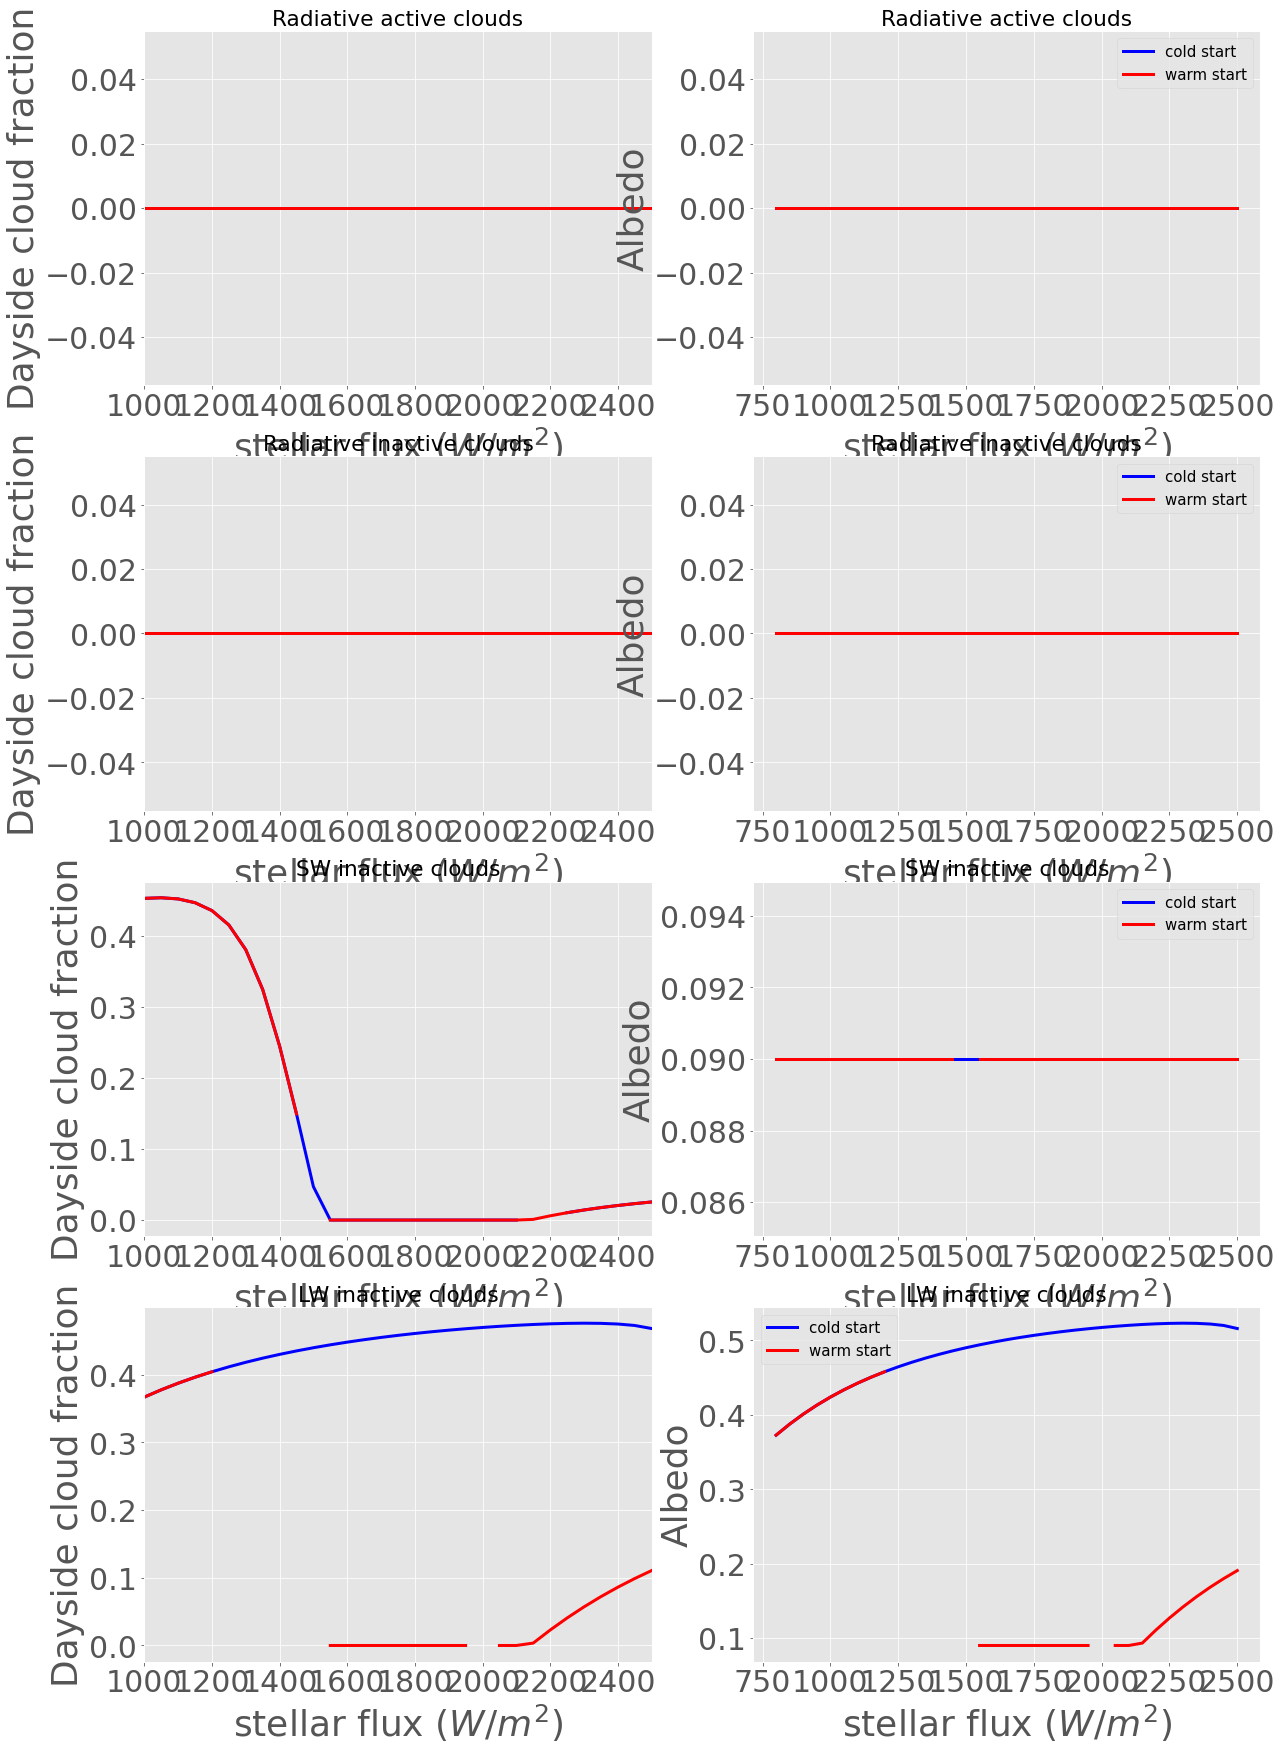

In [38]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.5
    
    fig, ax = plt.subplots(4, 2, figsize=(20,30)) 
    plt.rc('font', size = 15) 

    # Cloud fraction
    ax[0,0].plot(np.flip(so), fc_brr,'-', color = 'blue',linewidth=3, label = r'cold start')
    ax[0,0].plot(so, fc_crr,'-', color = 'red',linewidth=3, label = r'warm start')
    ax[0,0].set_xlim([1000, 2500])
    ax[0,0].set_ylabel("Dayside cloud fraction")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'Radiative active clouds')
    
    # Albedo
    ax[0,1].plot(np.flip(so), alpha_p_brr, '-', color = 'blue',linewidth=3, label = "cold start")
    ax[0,1].plot(so, alpha_p_crr, '-', color = 'red', linewidth=3, label = "warm start")
    ax[0,1].set_ylabel("Albedo")
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'Radiative active clouds')
    ax[0,1].legend()
        
    # Cloud fraction
    ax[1,0].plot(np.flip(so), fc_brr1,'-', color = 'blue',linewidth=3, label = r'cold start')
    ax[1,0].plot(so, fc_crr1,'-', color = 'red',linewidth=3, label = r'warm start')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel("Dayside cloud fraction")
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].set_title(r'Radiative inactive clouds')
    
    # Albedo
    ax[1,1].plot(np.flip(so), alpha_p_brr1, '-', color = 'blue',linewidth=3, label = "cold start")
    ax[1,1].plot(so, alpha_p_crr1, '-', color = 'red', linewidth=3, label = "warm start")
    ax[1,1].set_ylabel("Albedo")
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].set_title(r'Radiative inactive clouds')
    ax[1,1].legend()

    # Cloud fraction
    ax[2,0].plot(np.flip(so), fc_brr2,'-', color = 'blue',linewidth=3, label = r'cold start')
    ax[2,0].plot(so, fc_crr2,'-', color = 'red',linewidth=3, label = r'warm start')
    ax[2,0].set_xlim([1000, 2500])
    ax[2,0].set_ylabel("Dayside cloud fraction")
    ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,0].set_title(r'SW inactive clouds')
    
    # Albedo
    ax[2,1].plot(np.flip(so), alpha_p_brr2, '-', color = 'blue',linewidth=3, label = "cold start")
    ax[2,1].plot(so, alpha_p_crr2, '-', color = 'red', linewidth=3, label = "warm start")
    ax[2,1].set_ylabel("Albedo")
    ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,1].set_title(r'SW inactive clouds')
    ax[2,1].legend()
    
    # Cloud fraction
    ax[3,0].plot(np.flip(so), fc_brr3,'-', color = 'blue',linewidth=3, label = r'cold start')
    ax[3,0].plot(so, fc_crr3,'-', color = 'red',linewidth=3, label = r'warm start')
    ax[3,0].set_xlim([1000, 2500])
    ax[3,0].set_ylabel("Dayside cloud fraction")
    ax[3,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,0].set_title(r'LW inactive clouds')
    
    # Albedo
    ax[3,1].plot(np.flip(so), alpha_p_brr3, '-', color = 'blue',linewidth=3, label = "cold start")
    ax[3,1].plot(so, alpha_p_crr3, '-', color = 'red', linewidth=3, label = "warm start")
    ax[3,1].set_ylabel("Albedo")
    ax[3,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,1].set_title(r'LW inactive clouds')
    ax[3,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

In [ ]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_brrr, T2_brrr, T3_brrr, T4_brrr, Fa_brrr, Fc_brrr, fc_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brrr, q2_brrr, q3_brrr, alpha_p_brrr, epsilon_2_brrr, epsilon_3_brrr, OLR1_brrr, OLR2_brrr, Flux1_brrr, Flux2_brrr, Flux3_brrr, Flux4_brrr, FluxC_brrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,200,200,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx], fc_brrr[idx], \
        q1_brrr[idx],q2_brrr[idx],q3_brrr[idx],alpha_p_brrr[idx],epsilon_2_brrr[idx],epsilon_3_brrr[idx], \
        OLR1_brrr[idx], OLR2_brrr[idx], Flux1_brrr[idx], Flux2_brrr[idx], Flux3_brrr[idx], Flux4_brrr[idx], FluxC_brrr[idx], info,ier,msg = solar_abs_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_brrr[idx], T2_brrr[idx], T3_brrr[idx], T4_brrr[idx], Fa_brrr[idx], Fc_brrr[idx])
    #print('end of loop ',initial_guess)

In [ ]:
# check the role of atmospheric circulation (Fa = 0)

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def no_circ_func(So=1360, Fo=0, a_2 = 0.5, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, Fc = p 
#         T1, T2, T3, T4, Fa, Fc = p     
        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
#         RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
#         # water vapor calculations for nightside atmosphere
#         es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
#         ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
#         w_3 = RH3 * ws_3
#         q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
#         a_2 = 0.9 # water vapor absorption to sunlight
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a_2) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a_2 + Fc + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

#         Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

#         Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
#         Eq6_WTG = T2 - T3      # weak temperature gradient assumption

#         Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
#         # nightside outgoing longwave radiation
#         OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
#         Flux3 = epsilon_3*sigma*T3**4
#         Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
#             Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
#             Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq7)
#             return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2)
#             return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
#     (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, Fc))
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
#     fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
#     if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
#         print('cloud fraction: ',fc_2)
#         fc_2 = 1
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,alpha_p,epsilon_2,OLR_day, Flux1, Flux2 = equations((T1, T2, Fc))
#     fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, Fc, fc, q1, q2, alpha_p, epsilon_2, OLR_day, Flux1, Flux2, FluxC, info,ier,msg)
#     if debug==False: # Clean mode, only output prescribed variables
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
#     else:            # Debug mode, output the messages from fsolve function
#         return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [ ]:
# Example debug mode
S = 1200       # W/m2
T1_init = 328  # K
T2_init = 314  # K
Fc_init = 318  # W/m2

no_circ_func(So=S, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, Fc_init))

In [ ]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, alpha_p_crr, epsilon_2_crr, OLR1_crr, Flux1_crr, Flux2_crr, FluxC_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], Fc_crr[idx], fc_crr[idx], \
        q1_crr[idx],q2_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx], \
        OLR1_crr[idx], Flux1_crr[idx], Flux2_crr[idx], FluxC_crr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.5, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_crr[idx], T2_crr[idx], Fc_crr[idx])
    #print('end of loop ',initial_guess)

In [ ]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(1000,2500,16) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_crrr, T2_crrr, Fc_crrr, fc_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crrr, q2_crrr, alpha_p_crrr, epsilon_2_crrr, OLR1_crrr, Flux1_crrr, Flux2_crrr, FluxC_crrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx], fc_crrr[idx], \
        q1_crrr[idx],q2_crrr[idx],alpha_p_crrr[idx],epsilon_2_crrr[idx], \
        OLR1_crrr[idx], Flux1_crrr[idx], Flux2_crrr[idx], FluxC_crrr[idx], info,ier,msg = no_circ_func(So = s, a_2 = 0.9, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_crrr[idx], T2_crrr[idx], Fc_crrr[idx])
    #print('end of loop ',initial_guess)

In [ ]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(1, 2, figsize=(35,10)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[0].plot(so, T1_brrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[0].plot(so, T2_brrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[0].set_ylabel(r'$T$ (K)')
    ax[0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0].set_title(r'a = 0.5')
    ax[0].legend()
    
    # Nightside temperature structure
    ax[1].plot(so, T1_crr, '-', color = 'red',linewidth=3, label = r'$T_{1, double\;column}$')
    ax[1].plot(so, T1_crrr, '--', color = 'red', linewidth=3, label = r'$T_{1, single\;column}$')
    ax[1].plot(so, T2_crr, '-', color = 'blue', linewidth=3, label = r'$T_{2, doulbe\;column}$')
    ax[1].plot(so, T2_crrr, '--', color = 'blue',linewidth=3, label = r'$T_{2, single\;column}$')
    ax[1].set_ylabel(r'$T$ (K)')
    ax[1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1].set_title(r'a = 0.9')
    ax[1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [ ]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_brr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T1_crr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9, F_a = 0}$')
    ax[0,0].plot(so, T2_brr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].plot(so, T2_crr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9, F_a = 0}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
#     # Nightside temperature structure
#     ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
#     ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
#     ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
#     ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
#     ax[0,1].set_ylabel(r'$T$ (K)')
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,1].legend()
    
#     # Dayside energy budgets
#     ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
#     ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
#     ax[1,0].set_xlim([1000, 2500])
#     ax[1,0].set_ylabel(r'$W/m^2$')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].legend()
    
#     # Nightside energy budgets
#     ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
#     ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
#     ax[1,1].set_xlim([1000, 2500])
#     ax[1,1].set_ylabel(r'$W/m^2$')
#     ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [ ]:
print("Check variables")
print("T1 = {} K".format(round(T1_brr[0],2)))
print("T2 = {} K".format(round(T2_brr[0],2)))
print("T3 = {} K".format(round(T3_brr[0],2)))
print("T4 = {} K".format(round(T4_brr[0],2)))
print("F_a = {} W/m2".format(round(Fa_brr[0],2)))
print("F_c = {} W/m2".format(round(Fc_brr[0],2)))
print("dayside cloud fraction = {}".format(round(fc_brr[0],2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1_brr[0],4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2_brr[0],4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3_brr[0],6)))
print("planetary albedo = {}".format(round(alpha_p_brr[0],3)))
print("dayside emissivity = {}".format(round(epsilon_2_brr[0],3)))
print("nightside emissivity = {}".format(round(epsilon_3_brr[0],3)))
print("dayside OLR = {} W/m2".format(round(OLR1_brr[0],1)))
print("nightside OLR = {} W/m2".format(round(OLR2_brr[0],1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1_brr[0],1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2_brr[0],1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC_brr[0],1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3_brr[0],1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4_brr[0],1)))

In [ ]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_brr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_brr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
    ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [ ]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.9
    
    fig, ax = plt.subplots(2, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, alpha_p_arr, '-', color = 'red',linewidth=3, label = "a=0")
    ax[0,0].plot(so, alpha_p_brr, '--', color = 'red', linewidth=3, label = "a=0.9")
    ax[0,0].set_ylabel("Albedo")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Dayside emmisivity
    ax[0,1].plot(so, fc_arr,'-', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0}$')
    ax[0,1].plot(so, fc_brr,'--', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0.9}$')
    ax[0,1].set_xlim([1000, 2500])
    ax[0,1].set_ylabel("Cloud fraction")
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Dayside energy budgets
    ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,0].plot(so, -sigma*T1_arr**4,'-', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0}$')
    ax[1,0].plot(so, -sigma*T1_brr**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0.9}$')
    ax[1,0].plot(so, (1-fc_arr)*Flux2_arr,'-', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0}$')
    ax[1,0].plot(so, (1-fc_brr)*Flux2_brr,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0.9}$')
    ax[1,0].plot(so, -Fc_arr,'-', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0}$')
    ax[1,0].plot(so, -Fc_brr,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0.9}$')
    ax[1,0].plot(so, fc_arr*sigma*Tc**4,'-', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0}$')
    ax[1,0].plot(so, fc_brr*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0.9}$')  
    
#     ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr) + fc_arr*sigma*Tc**4 - sigma*T1_arr**4 + (1-fc_arr)*Flux2_arr - Fc_arr,'-', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0}$')
#     ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr) + fc_brr*sigma*Tc**4 - sigma*T1_brr**4 + (1-fc_brr)*Flux2_brr - Fc_brr,'--', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    ax[1,0].set_title("Much weaker convective cooling, mucher weaker solar heating, \n stronger atmos heating, weaker cloud heating")
    
    # Nightside energy budgets
    ax[1,1].plot(so, Fc_arr,'-', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0}$')
    ax[1,1].plot(so, Fc_brr,'--', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0.9}$')
    ax[1,1].plot(so, -Fa_arr,'-', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0}$')
    ax[1,1].plot(so, -Fa_brr,'--', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0.9}$')
    ax[1,1].plot(so, so/2*(1-1)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,1].plot(so, so/2*a*(1-alpha_p_arr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,1].plot(so, ((1-fc_arr)*epsilon_2_arr+fc_arr)*sigma*T1_arr**4,'-', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0}$')
    ax[1,1].plot(so, ((1-fc_brr)*epsilon_2_brr+fc_brr)*sigma*T1_brr**4,'--', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*(1-fc_arr)*epsilon_2_arr*sigma*T2_arr**4,'-', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0}$')
    ax[1,1].plot(so, -2*(1-fc_brr)*epsilon_2_brr*sigma*T2_brr**4,'--', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*fc_arr*sigma*Tc**4,'-', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0}$')
    ax[1,1].plot(so, -2*fc_brr*sigma*Tc**4,'--', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    ax[1,1].set_title("Much weaker convective heating, mucher stronger solar heating, \n stronger heat advection, stronger surf emission, \n weaker cloud cooling")
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)